Secure ETL & Data Engineering to Build a controlled data ingestion and preprocessing pipeline.  
  
Data-Simulated datasets  
sensor_logs.csv  
mission_profile.json  
maintenance_records.csv  
  
✔ Ingest multi-source data  
✔ Merge using Equipment ID & Timestamp  
✔ Handle missing sensor data  
Feature engineering:  
rolling averages  
risk indicators  
categorical encoding  

In [ ]:
%load_ext autoreload
%autoreload 2
# Do not run this cell unless running the code on a local notebook. This line is for auto-reloading the code in the notebook whenever you make changes to the code files. 
# If you're running this code in a Jupyter notebook/ Google Colab, you can uncomment the line to enable auto-reloading of your code files.

In [ ]:
%pip install pandas numpy scikit-learn matplotlib sqlite3 #ipykernel # Uncomment this line if running in a Jupyter notebook locally
# This line ensures that the necessary libraries are installed. If you're running this code in a Jupyter notebook/ Google Colab, you can uncomment the line to install the libraries directly from the notebook.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


In [2]:
# -----------------------
# 1) Load data
# -----------------------
DATA_DIR = "./dataset"

# 1) Sensor logs
sensor = pd.read_csv(f"{DATA_DIR}/sensor_logs.csv")

required_sensor_cols = {"asset_id", "timestamp"}
missing = required_sensor_cols - set(sensor.columns)
if missing:
    raise KeyError(f"sensor_logs.csv missing columns: {missing}. Found: {list(sensor.columns)}")

sensor["timestamp"] = pd.to_datetime(sensor["timestamp"], errors="coerce")
sensor = sensor.dropna(subset=["timestamp"]).sort_values(["asset_id", "timestamp"]).reset_index(drop=True)

# 2) Mission profile (JSON list of records)
with open(f"{DATA_DIR}/mission_profile.json", "r", encoding="utf-8") as f:
    mission_raw = json.load(f)

mission = pd.json_normalize(mission_raw if isinstance(mission_raw, list) else [mission_raw])

if "asset_id" not in mission.columns:
    raise KeyError(f"mission_profile.json must contain 'asset_id'. Found: {list(mission.columns)}")

# 3) Maintenance records
maint = pd.read_csv(f"{DATA_DIR}/maintenance_records.csv")

required_maint_cols = {"asset_id", "event_time"}
missing = required_maint_cols - set(maint.columns)
if missing:
    raise KeyError(f"maintenance_records.csv missing columns: {missing}. Found: {list(maint.columns)}")

maint["event_time"] = pd.to_datetime(maint["event_time"], errors="coerce")
maint = maint.dropna(subset=["event_time"]).sort_values(["asset_id", "event_time"]).reset_index(drop=True)

print("Loaded:")
print(" sensor:", sensor.shape)
print(" mission:", mission.shape)
print(" maint :", maint.shape)



Loaded:
 sensor: (1197, 7)
 mission: (120, 7)
 maint : (357, 7)


In [3]:
# -----------------------
# 2) Feature engineering
#    a) rolling averages (per asset)
# -----------------------
# Pick numeric sensor columns automatically (excluding id + time)
num_sensor_cols = [
    c for c in sensor.columns
    if c not in ["asset_id", "timestamp"] and pd.api.types.is_numeric_dtype(sensor[c])
]

# Rolling mean over last 5 rows (simple + minimal)
for c in num_sensor_cols:
    sensor[f"{c}_rollmean_5"] = (
        sensor.groupby("asset_id")[c]
        .rolling(window=5, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
sensor.head(10)  # Display first 10 rows of the updated sensor DataFrame



,asset_id,timestamp,temperature,vibration,pressure,rpm,voltage,temperature_rollmean_5,vibration_rollmean_5,pressure_rollmean_5,rpm_rollmean_5,voltage_rollmean_5
0,ASSET_001,2026-01-20 08:09:00,71.207361,3.115513,31.731311,1417.259726,24.433562,71.207361,3.115513,31.731311,1417.259726,24.433562
1,ASSET_001,2026-01-20 09:02:00,68.143942,2.121417,30.291502,1301.629047,24.953733,69.675652,2.618465,31.011407,1359.444387,24.693647
2,ASSET_001,2026-01-20 10:07:00,76.045131,2.488385,34.596099,1414.203976,23.750564,71.798811,2.575105,32.206304,1377.697583,24.379286
3,ASSET_001,2026-01-20 11:02:00,72.070129,0.613351,32.483764,1700.411951,24.901445,71.866641,2.084666,32.275669,1458.376175,24.509826
4,ASSET_001,2026-01-20 12:04:00,69.167647,3.404850,33.222092,1551.040710,24.004091,71.326842,2.348703,32.464954,1476.909082,24.408679
5,ASSET_001,2026-01-20 13:01:00,67.872913,NaN,33.678688,1217.634295,23.703882,70.659953,2.157001,32.854429,1436.983996,24.262743
6,ASSET_001,2026-01-20 14:05:00,75.202802,3.788657,32.979971,1462.102215,24.582502,72.071725,2.573811,33.392123,1469.078629,24.188497
7,ASSET_001,2026-01-20 15:02:00,62.473913,3.523279,29.530574,1412.411311,23.488752,69.357481,2.832534,32.379018,1468.720096,24.136135
8,ASSET_001,2026-01-20 16:04:00,67.686805,4.211256,27.845457,1504.239007,24.022440,68.480816,3.732010,31.451356,1429.485507,23.960333
9,ASSET_001,2026-01-20 17:00:00,70.213147,2.423605,28.555311,1424.157025,23.310272,68.689916,3.486699,30.518000,1404.108770,23.821570


In [4]:
# -----------------------
# 2b) risk indicators
# -----------------------
# Simple thresholds (change to match your columns)
THRESHOLDS = {"temperature": 85, "vibration": 4.5}

risk_flag_cols = []
for col, thr in THRESHOLDS.items():
    if col in sensor.columns:
        flag = f"risk_{col}_high"
        sensor[flag] = (sensor[col] > thr).astype(int)
        risk_flag_cols.append(flag)

# Aggregate score (works even if only 1 flag exists)
sensor["risk_score"] = sensor[risk_flag_cols].sum(axis=1) if risk_flag_cols else 0
sorted(sensor["risk_score"].unique())    # Check unique risk scores after aggregation


[np.int64(0), np.int64(1), np.int64(2)]

In [5]:
# -----------------------
# 3) Join datasets
#    mission: plain left join
#    maintenance: "last maintenance event before this sensor timestamp"
# -----------------------
df = sensor.merge(mission, on="asset_id", how="left")

# merge_asof needs sorted frames
df = df.sort_values(["asset_id", "timestamp"])
maint = maint.sort_values(["asset_id", "event_time"])

# asof join per asset (minimal & correct)
out = []
for asset_id, g in df.groupby("asset_id", sort=False):
    m = maint[maint["asset_id"] == asset_id]
    if m.empty:
        out.append(g)
        continue
    out.append(
        pd.merge_asof(
            g.sort_values("timestamp"),
            m.sort_values("event_time"),
            left_on="timestamp",
            right_on="event_time",
            direction="backward",
        )
    )

df = pd.concat(out, ignore_index=True)

df.head(10)


,asset_id_x,timestamp,temperature,vibration,pressure,rpm,voltage,temperature_rollmean_5,vibration_rollmean_5,pressure_rollmean_5,...,payload_kg,route_length_km,priority,asset_id_y,event_time,maintenance_type,downtime_hours,technician,parts_replaced,cost_usd
0,ASSET_001,2026-01-20 08:09:00,71.207361,3.115513,31.731311,1417.259726,24.433562,71.207361,3.115513,31.731311,...,8.236864,259.64559,low,ASSET_001,2026-01-17 13:00:00,inspection,1.703292,R.Kumar,bearing,548.136775
1,ASSET_001,2026-01-20 09:02:00,68.143942,2.121417,30.291502,1301.629047,24.953733,69.675652,2.618465,31.011407,...,8.236864,259.64559,low,ASSET_001,2026-01-17 13:00:00,inspection,1.703292,R.Kumar,bearing,548.136775
2,ASSET_001,2026-01-20 10:07:00,76.045131,2.488385,34.596099,1414.203976,23.750564,71.798811,2.575105,32.206304,...,8.236864,259.64559,low,ASSET_001,2026-01-17 13:00:00,inspection,1.703292,R.Kumar,bearing,548.136775
3,ASSET_001,2026-01-20 11:02:00,72.070129,0.613351,32.483764,1700.411951,24.901445,71.866641,2.084666,32.275669,...,8.236864,259.64559,low,ASSET_001,2026-01-17 13:00:00,inspection,1.703292,R.Kumar,bearing,548.136775
4,ASSET_001,2026-01-20 12:04:00,69.167647,3.404850,33.222092,1551.040710,24.004091,71.326842,2.348703,32.464954,...,8.236864,259.64559,low,ASSET_001,2026-01-20 11:15:00,inspection,2.393138,M.Iyer,pump,198.566761
5,ASSET_001,2026-01-20 13:01:00,67.872913,NaN,33.678688,1217.634295,23.703882,70.659953,2.157001,32.854429,...,8.236864,259.64559,low,ASSET_001,2026-01-20 11:15:00,inspection,2.393138,M.Iyer,pump,198.566761
6,ASSET_001,2026-01-20 14:05:00,75.202802,3.788657,32.979971,1462.102215,24.582502,72.071725,2.573811,33.392123,...,8.236864,259.64559,low,ASSET_001,2026-01-20 11:15:00,inspection,2.393138,M.Iyer,pump,198.566761
7,ASSET_001,2026-01-20 15:02:00,62.473913,3.523279,29.530574,1412.411311,23.488752,69.357481,2.832534,32.379018,...,8.236864,259.64559,low,ASSET_001,2026-01-20 11:15:00,inspection,2.393138,M.Iyer,pump,198.566761
8,ASSET_001,2026-01-20 16:04:00,67.686805,4.211256,27.845457,1504.239007,24.022440,68.480816,3.732010,31.451356,...,8.236864,259.64559,low,ASSET_001,2026-01-20 11:15:00,inspection,2.393138,M.Iyer,pump,198.566761
9,ASSET_001,2026-01-20 17:00:00,70.213147,2.423605,28.555311,1424.157025,23.310272,68.689916,3.486699,30.518000,...,8.236864,259.64559,low,ASSET_001,2026-01-20 16:45:00,overhaul,1.890631,J.Verma,bearing,280.075074


In [6]:
# -----------------------
# 4) Categorical encoding (one-hot)
# -----------------------
cat_cols = [c for c in df.columns if df[c].dtype == "object"]
num_cols = [c for c in df.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

pipe = Pipeline([("preprocess", preprocess)])

X = pipe.fit_transform(df)


In [7]:
# Optional: feature names -> back to DataFrame
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
X_df = pd.DataFrame(X, columns=feature_names)

print("Final joined df shape:", df.shape)
print("Encoded matrix shape:", X_df.shape)


Final joined df shape: (1197, 28)
Encoded matrix shape: (1197, 28)


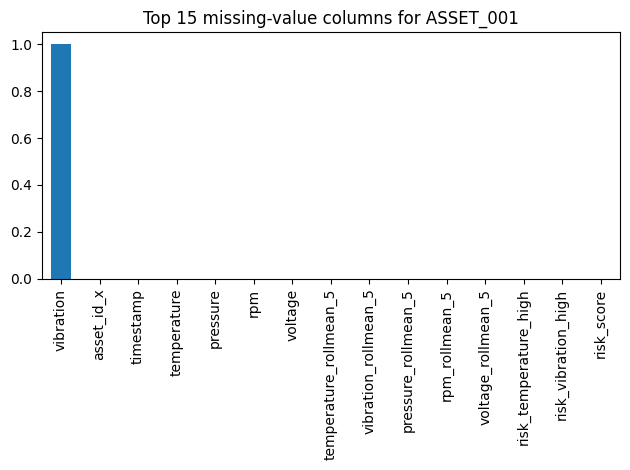

Inspecting asset: ASSET_001
Rows for this asset: 10


In [10]:
import matplotlib.pyplot as plt

# Pick one asset to inspect
asset = df['asset_id_x'].dropna().iloc[0]

# Filter to that asset only
d = df[df['asset_id_x'] == asset]

# Compute missing counts within that asset's records
na = d.isna().sum().sort_values(ascending=False).head(15)

plt.figure()
na.plot(kind="bar")
plt.title(f"Top 15 missing-value columns for {asset}")
plt.tight_layout()
plt.show()

print("Inspecting asset:", asset)
print("Rows for this asset:", len(d))

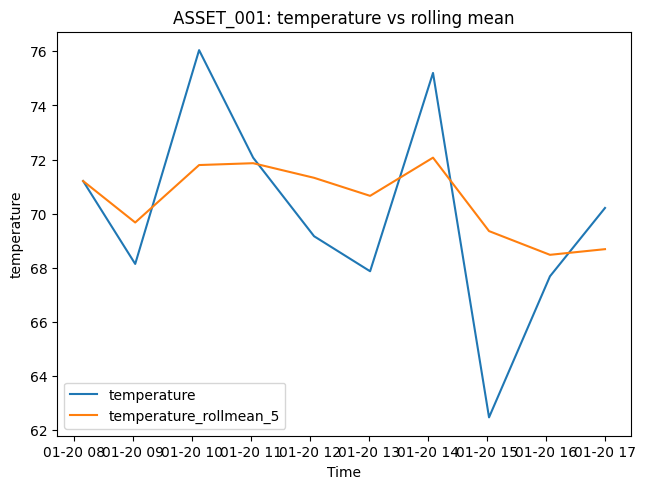

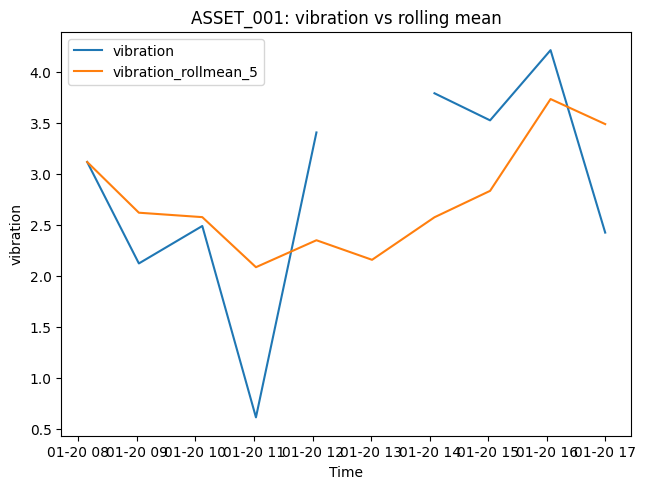

In [14]:
# 2) Raw vs rolling (example columns if present)
for col in ["temperature", "vibration"]:
    roll = f"{col}_rollmean_5"
    if col in d.columns and roll in d.columns:
        plt.figure()
        plt.plot(d["timestamp"], d[col], label=col)
        plt.plot(d["timestamp"], d[roll], label=roll)
        plt.title(f"{asset}: {col} vs rolling mean")
        plt.legend()
        plt.tight_layout()
        plt.xlabel("Time")
        plt.ylabel(col)
        plt.show()


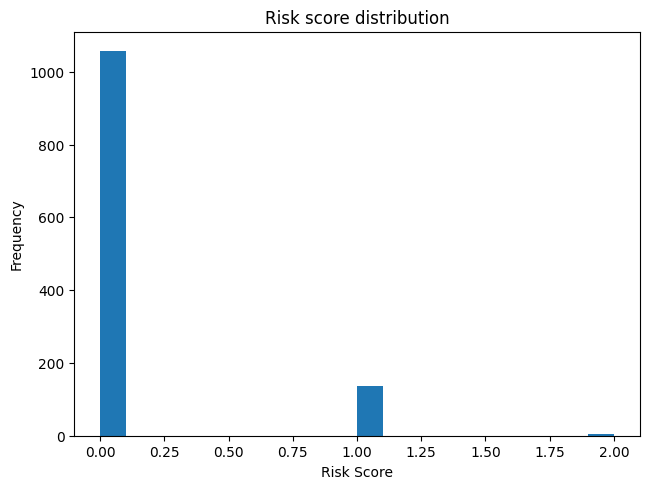

In [15]:
# 3) Risk score distribution
if "risk_score" in df.columns:
    plt.figure()
    plt.hist(df["risk_score"].dropna(), bins=20)
    plt.title("Risk score distribution")
    plt.tight_layout()
    plt.xlabel("Risk Score")
    plt.ylabel("Frequency")
    plt.show()


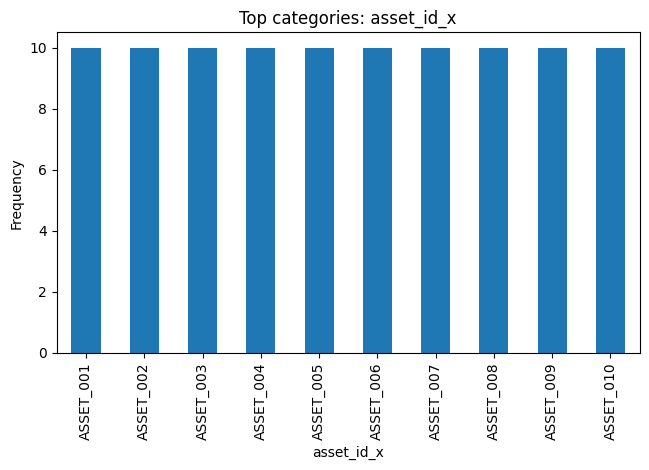

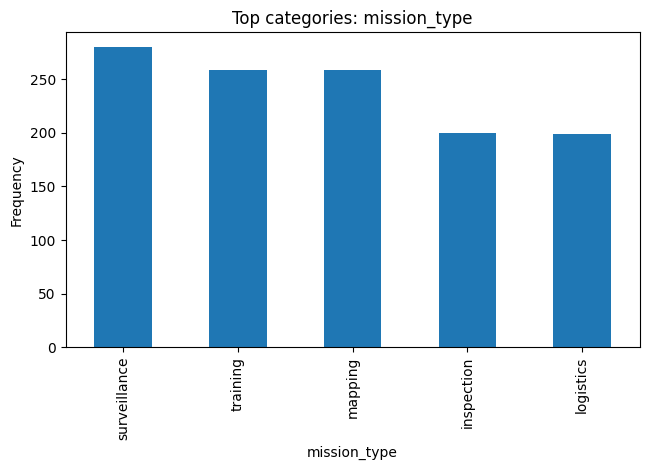

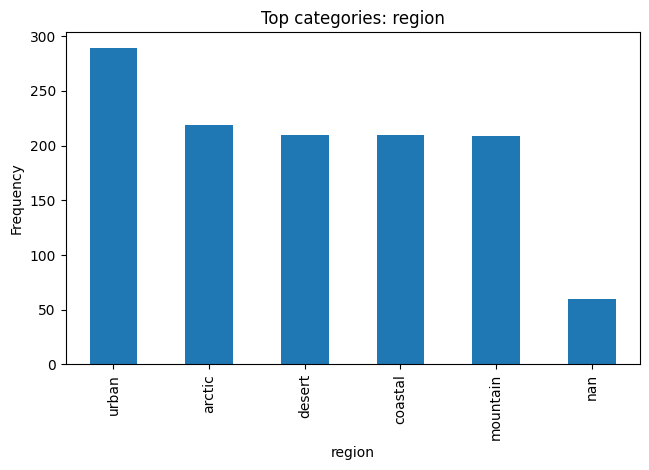

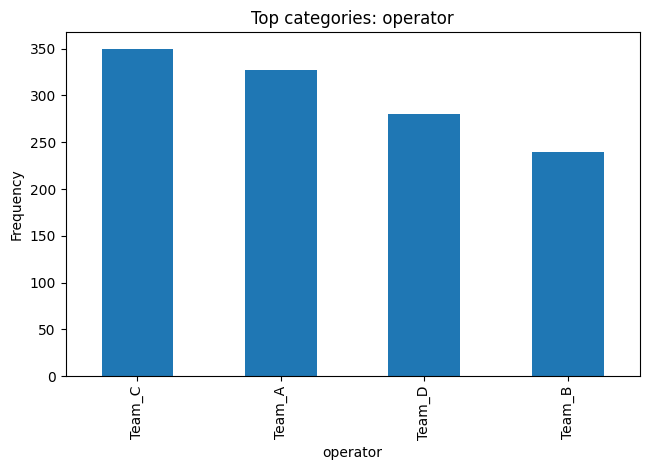

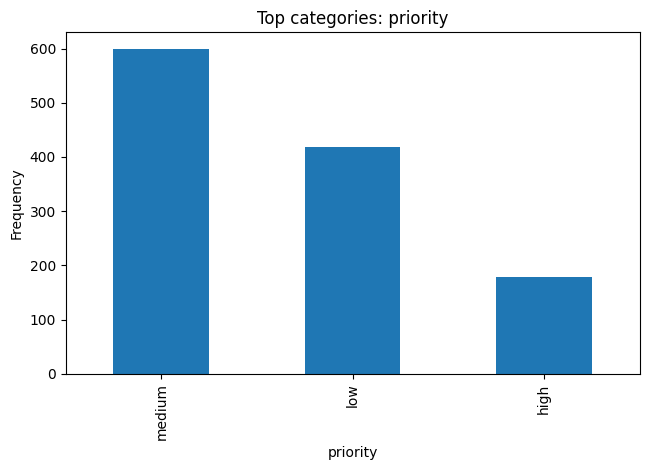

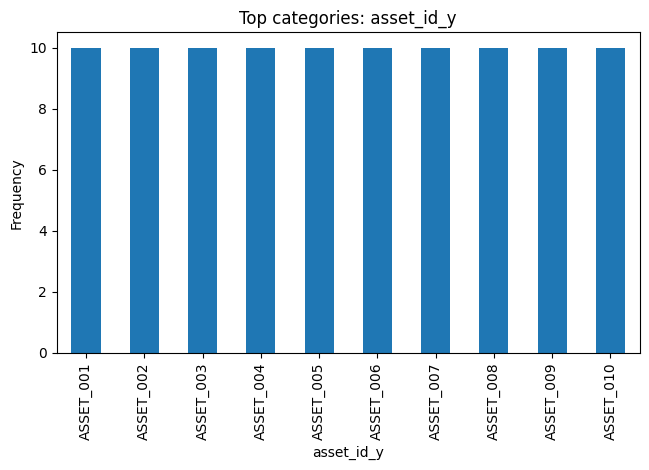

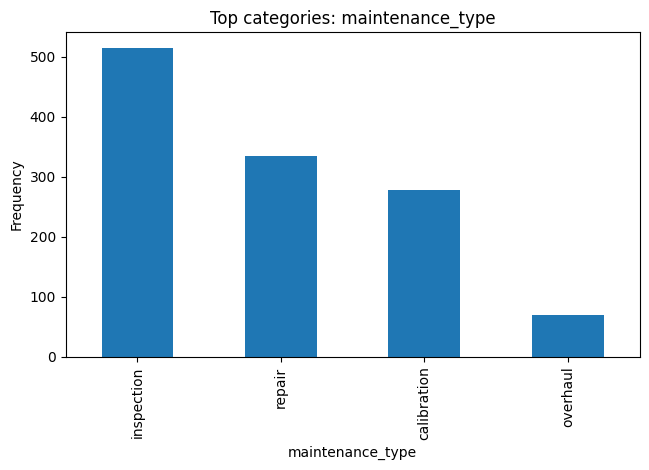

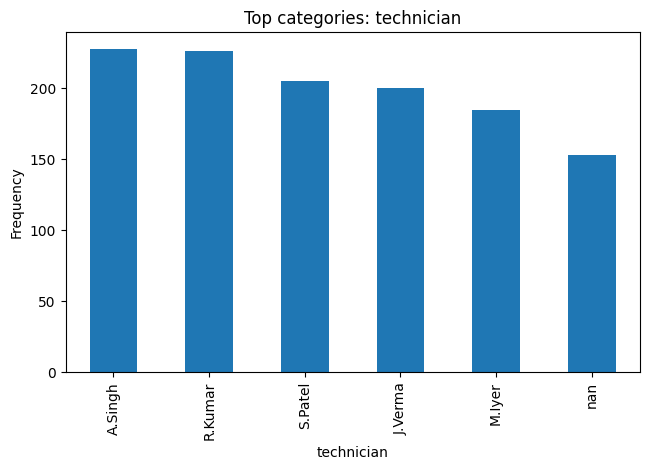

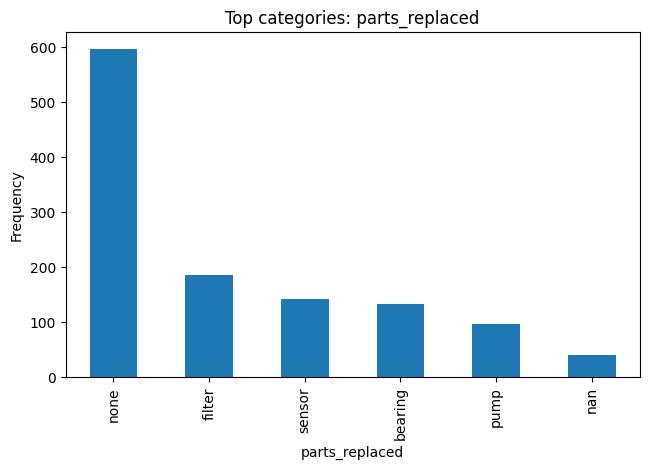

In [21]:
# 4) Categorical cardinality (top 10 per cat column)
cat_cols = [c for c in df.columns if df[c].dtype == "str"]
for c in cat_cols:  # limit to first 5 to keep it quick
    plt.figure()
    df[c].value_counts(dropna=False).head(10).plot(kind="bar")
    plt.title(f"Top categories: {c}")
    plt.tight_layout()
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.show()


In [23]:
# Write to SQLite

import sqlite3

DB_PATH = "etl_pipeline.db"  # Database Object

# Use the correct asset id column in your df
ASSET_COL = "asset_id_x" if "asset_id_x" in df.columns else "asset_id"

# SQLite works best with numeric time for indexes
if "timestamp_epoch" not in df.columns:
    df = df.copy()
    df["timestamp_epoch"] = df["timestamp"].astype("int64") // 10**9

with sqlite3.connect(DB_PATH) as conn:
    # Save joined + engineered data
    df.to_sql("etl_features_raw", conn, if_exists="replace", index=False)

    # Save encoded feature matrix
    X_df.to_sql("etl_features_encoded", conn, if_exists="replace", index=False)

    # Create indexes for faster lookup
    conn.execute(f"CREATE INDEX IF NOT EXISTS idx_raw_asset_time ON etl_features_raw({ASSET_COL}, timestamp_epoch)")
    conn.execute(f"CREATE INDEX IF NOT EXISTS idx_raw_asset ON etl_features_raw({ASSET_COL})")


In [24]:
# Verify by reading back

import pandas as pd
import sqlite3

with sqlite3.connect("etl_pipeline.db") as conn:
    df2 = pd.read_sql("SELECT * FROM etl_features_raw LIMIT 5", conn)
    X2  = pd.read_sql("SELECT * FROM etl_features_encoded LIMIT 5", conn)

print(df2.head())
print(X2.head())


  asset_id_x            timestamp  temperature  vibration   pressure  \
0  ASSET_001  2026-01-20 08:09:00    71.207361   3.115513  31.731311   
1  ASSET_001  2026-01-20 09:02:00    68.143942   2.121417  30.291502   
2  ASSET_001  2026-01-20 10:07:00    76.045131   2.488385  34.596099   
3  ASSET_001  2026-01-20 11:02:00    72.070129   0.613351  32.483764   
4  ASSET_001  2026-01-20 12:04:00    69.167647   3.404850  33.222092   

           rpm    voltage  temperature_rollmean_5  vibration_rollmean_5  \
0  1417.259726  24.433562               71.207361              3.115513   
1  1301.629047  24.953733               69.675652              2.618465   
2  1414.203976  23.750564               71.798811              2.575105   
3  1700.411951  24.901445               71.866641              2.084666   
4  1551.040710  24.004091               71.326842              2.348703   

   pressure_rollmean_5  ...  route_length_km  priority  asset_id_y  \
0            31.731311  ...        259.64559  

In [ ]:

# Save to CSV (optional)
df.to_csv("final_joined.csv", index=False)
X_df.to_csv("final_features_encoded.csv", index=False)
